<a href="https://colab.research.google.com/github/Soumayas/Calcul_des_incertitudes_de_mesure_en_utilisant_ML/blob/main/Pipeline_d'analyse_des_donn%C3%A9es_microbiomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chargement et prétraitement des données taxonomiques**



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Charger les données taxonomiques
taxonomic_data = pd.read_csv('/content/taxonomic_profiles (2).csv', sep=';', index_col=0)

# Exclure la colonne 'taxonomy'
data_numeric = taxonomic_data.drop(columns=['taxonomy'])

# Remplir les NaN avec la moyenne de chaque OTU
data_numeric.fillna(data_numeric.mean(), inplace=True)

# Transposer pour avoir les échantillons en lignes
X = data_numeric.T

print(f"Dimensions de X : {X.shape}")



Dimensions de X : (178, 982)


**Normalisation des données**



In [ ]:
# Transformation logarithmique
X_log = np.log10(X + 1)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print(f"Dimensions après normalisation : {X_scaled.shape}")


Dimensions après normalisation : (178, 982)


**Réduction de dimension (PCA pour visualisation) et Affichage de la Variance Expliquée**



Variance expliquée par chaque composante principale :
PC1 : 6.33%
PC2 : 5.35%
Total : 11.68%


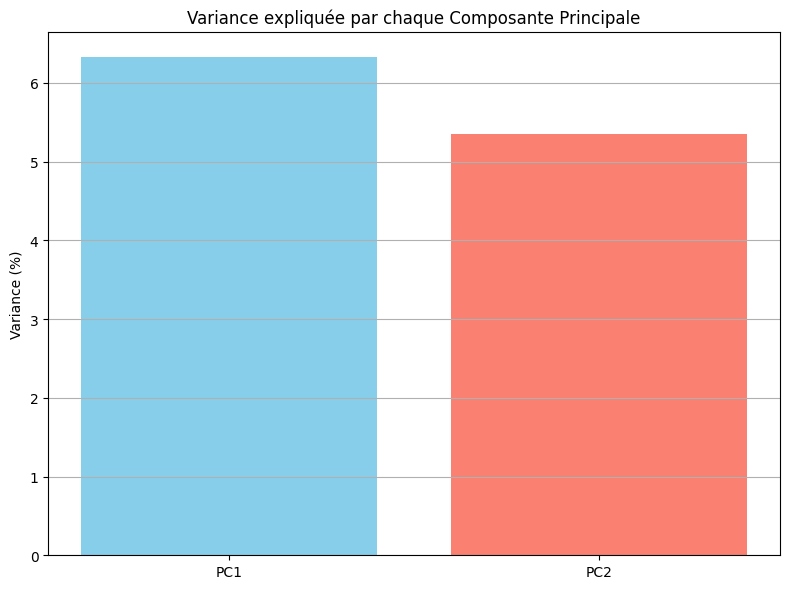

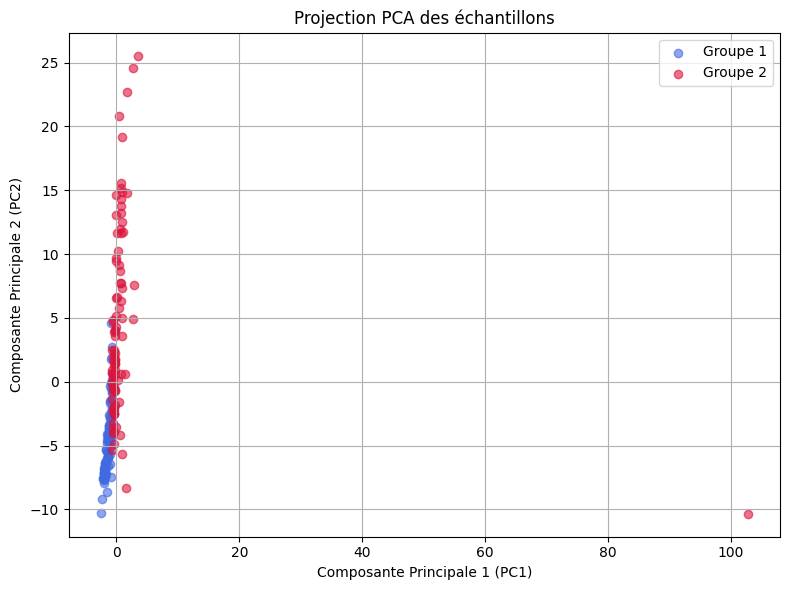

In [ ]:
# Réduction de dimension avec PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PCA - On conserve 2 composantes pour la visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Résultats de PCA
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=X.index)

# Affichage de la variance expliquée
explained_variance = pca.explained_variance_ratio_
print("\nVariance expliquée par chaque composante principale :")
print(f"PC1 : {explained_variance[0]:.2%}")
print(f"PC2 : {explained_variance[1]:.2%}")
print(f"Total : {(explained_variance[0] + explained_variance[1]):.2%}")

# Barplot Variance Expliquée
plt.figure(figsize=(8, 6))
plt.bar(['PC1', 'PC2'], explained_variance * 100, color=['skyblue', 'salmon'])
plt.title('Variance expliquée par chaque Composante Principale')
plt.ylabel('Variance (%)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#  Visualisation 2D PCA avec couleurs
pca_df['group'] = (pca_df['PC1'] > pca_df['PC1'].median()).astype(int)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df.loc[pca_df['group'] == 0, 'PC1'],
            pca_df.loc[pca_df['group'] == 0, 'PC2'],
            color='royalblue', alpha=0.6, label='Groupe 1')
plt.scatter(pca_df.loc[pca_df['group'] == 1, 'PC1'],
            pca_df.loc[pca_df['group'] == 1, 'PC2'],
            color='crimson', alpha=0.6, label='Groupe 2')
plt.title('Projection PCA des échantillons')
plt.xlabel('Composante Principale 1 (PC1)')
plt.ylabel('Composante Principale 2 (PC2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PCA automatique pour atteindre 95% de variance expliquée

In [ ]:
from sklearn.decomposition import PCA

# PCA automatique - conserve le nombre de composantes expliquant 95% de la variance
pca_auto = PCA(n_components=0.95)
X_pca_auto = pca_auto.fit_transform(X_scaled)

print(f"Nombre de composantes conservées : {X_pca_auto.shape[1]}")
print(f"Variance expliquée totale : {np.sum(pca_auto.explained_variance_ratio_):.2%}")


Nombre de composantes conservées : 120
Variance expliquée totale : 95.09%


**Réduction de dimension (SVD)**

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X_pca.shape[1], random_state=42)
X_svd = svd.fit_transform(X_scaled)
print(f"SVD - Nombre de composantes: {X_svd.shape[1]}")
print(f"SVD - Variance expliquée: {svd.explained_variance_ratio_.sum():.2%}")

SVD - Nombre de composantes: 2
SVD - Variance expliquée: 11.68%


 t-SNE

t-SNE - Dimensions de sortie : (178, 2)


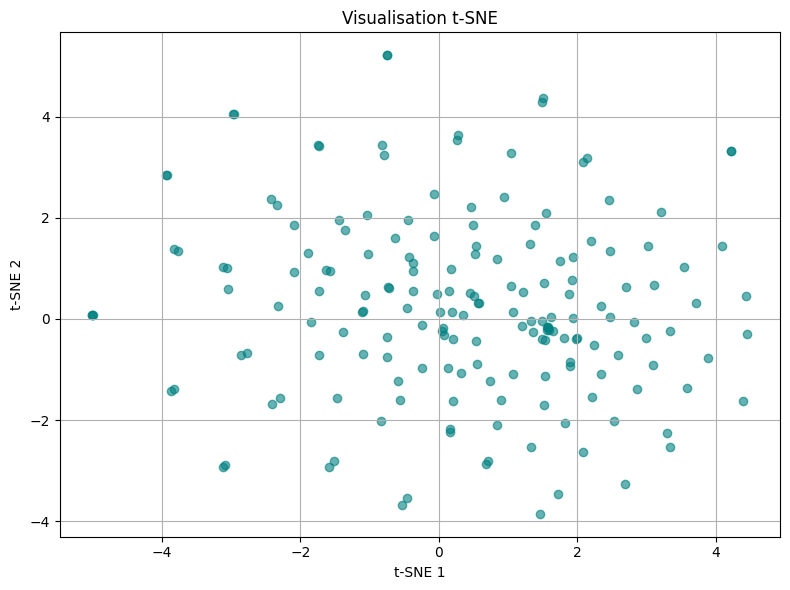

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE - Dimensions de sortie :", X_tsne.shape)
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c='teal', alpha=0.6)
plt.title("Visualisation t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


**UMAP**

In [ ]:
# Installation UMAP
!pip install umap-learn


UMAP - Dimensions de sortie : (178, 2)


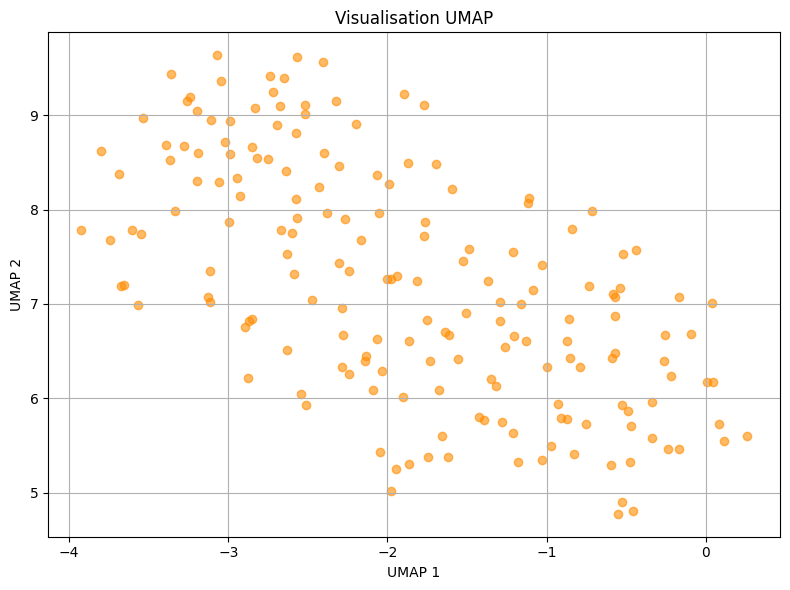

In [ ]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)
print("UMAP - Dimensions de sortie :", X_umap.shape)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c='darkorange', alpha=0.6)
plt.title("Visualisation UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


**Chargement et nettoyage des métadonnées**

In [ ]:
meta = pd.read_csv('/content/hmp2_metadata_2018-08-20 (1).csv', sep=';', low_memory=False)
meta = meta[["External ID", "diagnosis", "is_inflamed"]]
meta = meta[pd.to_numeric(meta["External ID"], errors='coerce').notnull()]
meta["External ID"] = meta["External ID"].astype(int)
meta = meta.dropna(subset=["diagnosis", "is_inflamed"])
print(f"Dimensions des métadonnées nettoyées : {meta.shape}")
print(meta.head())


Dimensions des métadonnées nettoyées : (178, 3)
   External ID diagnosis is_inflamed
0       206615        CD         Yes
1       206614        CD         Yes
2       206617        CD         Yes
3       206619        CD         Yes
4       206616        CD         Yes


**Alignement des Données + Cible Binaire**

In [ ]:
X.index = X.index.astype(int)
common_ids = X.index.intersection(meta["External ID"])
meta_final = meta.set_index("External ID").loc[common_ids]
y = (meta_final["is_inflamed"].str.strip().str.lower() == "yes").astype(int).values

# Pour les 4 méthodes : choisir ici le dataset réduit à utiliser
# Exemple :
# X_final = X_pca  # PCA 95%
# X_final = X_svd  # SVD
# X_final = X_tsne # t-SNE
# X_final = X_umap # UMAP

X_final = X_pca
print(f"Dimensions X_final : {X_final.shape}")
print(f"Dimensions y : {y.shape}")


Dimensions X_final : (178, 2)
Dimensions y : (178,)


**Classification avec Random Forest + Gestion Déséquilibre**

In [ ]:
# Classification avec Random Forest sur toutes les méthodes de réduction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Vérification des données d'entrée
try:
    if 'X_pca' not in globals() or 'X_tsne' not in globals() or 'X_umap' not in globals() or 'y' not in globals():
        raise NameError("X_pca, X_tsne, X_umap ou y n'est pas défini. Exécutez les cellules précédentes.")
    if X_pca.shape[0] == 0 or X_tsne.shape[0] == 0 or X_umap.shape[0] == 0 or len(y) == 0:
        raise ValueError("Une des entrées est vide.")
    if X_pca.shape[0] != len(y) or X_tsne.shape[0] != len(y) or X_umap.shape[0] != len(y):
        raise ValueError("Les dimensions de X_pca, X_tsne, X_umap et y sont incompatibles.")
except Exception as e:
    print(f"Erreur d'entrée : {e}")
    raise

# Liste des méthodes de réduction
methods = ['PCA', 't-SNE', 'UMAP']
X_dict = {
    'PCA': X_pca,
    't-SNE': X_tsne,
    'UMAP': X_umap
}

# Résultats
results = {}
for method in methods:
    X_final = X_dict[method]
    print(f"\n=== Classification avec {method} ===")

    # Application de SMOTE
    try:
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_balanced, y_balanced = smote.fit_resample(X_final, y)
        print(f"Dimensions après SMOTE : X={X_balanced.shape}, y={y_balanced.shape}")
        print(f"Distribution des classes après SMOTE : {np.bincount(y_balanced)}")
    except ValueError as e:
        print(f"Erreur SMOTE pour {method} : {e}. Utilisation des données non équilibrées.")
        X_balanced, y_balanced = X_final, y

    # Division en ensembles d'entraînement, validation et test
    try:
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
        )
        print(f"Dimensions train : {X_train.shape}, validation : {X_val.shape}, test : {X_test.shape}")
    except Exception as e:
        print(f"Erreur lors de la division des données pour {method} : {e}")
        continue

    # Configuration de Random Forest avec GridSearchCV
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [2, 4],
        'class_weight': ['balanced']
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search_rf = GridSearchCV(
        rf, param_grid_rf, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1_weighted', n_jobs=-1
    )
    grid_search_rf.fit(X_train, y_train)

    # Meilleur modèle
    best_rf = grid_search_rf.best_estimator_
    print(f"Meilleurs paramètres Random Forest ({method}) : {grid_search_rf.best_params_}")

    # Évaluation sur l'ensemble de validation
    y_val_pred = best_rf.predict(X_val)
    print(f"\nRapport de classification Random Forest ({method}, validation) :")
    report_val = classification_report(y_val, y_val_pred, zero_division=0)
    print(report_val)
    print(f"Matrice de confusion Random Forest ({method}, validation) :")
    print(confusion_matrix(y_val, y_val_pred))
    balanced_acc_val = balanced_accuracy_score(y_val, y_val_pred)
    print(f"Précision équilibrée Random Forest ({method}, validation) : {balanced_acc_val:.2f}")

    # AUROC sur validation
    auroc_val = np.nan
    if len(np.unique(y_val)) > 1:
        y_val_proba = best_rf.predict_proba(X_val)[:, 1]
        auroc_val = roc_auc_score(y_val, y_val_proba)
    print(f"AUROC Random Forest ({method}, validation) : {auroc_val:.2f}")

    # Validation croisée
    scores_rf = cross_val_score(
        best_rf, X_balanced, y_balanced, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1_weighted'
    )
    print(f"Scores F1 CV Random Forest ({method}) : {scores_rf}")
    print(f"Moyenne F1 Random Forest ({method}) : {np.mean(scores_rf):.2f} ± {np.std(scores_rf):.2f}")

    # Évaluation sur l'ensemble de test
    y_test_pred = best_rf.predict(X_test)
    print(f"\nRapport de classification Random Forest ({method}, test) :")
    report_test = classification_report(y_test, y_test_pred, zero_division=0)
    print(report_test)
    print(f"Matrice de confusion Random Forest ({method}, test) :")
    print(confusion_matrix(y_test, y_test_pred))
    balanced_acc_test = balanced_accuracy_score(y_test, y_test_pred)
    print(f"Précision équilibrée Random Forest ({method}, test) : {balanced_acc_test:.2f}")

    # AUROC sur test
    auroc_test = np.nan
    if len(np.unique(y_test)) > 1:
        y_test_proba = best_rf.predict_proba(X_test)[:, 1]
        auroc_test = roc_auc_score(y_test, y_test_proba)
    print(f"AUROC Random Forest ({method}, test) : {auroc_test:.2f}")

    # Visualisation des clusters
    if X_balanced.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_balanced[y_balanced == 0, 0], X_balanced[y_balanced == 0, 1], c='blue', alpha=0.5, label='Non inflammatoire')
        plt.scatter(X_balanced[y_balanced == 1, 0], X_balanced[y_balanced == 1, 1], c='red', alpha=0.5, label='Inflammatoire')
        plt.title(f'Clusters biologiques - {method}')
        plt.xlabel(f'{method}1')
        plt.ylabel(f'{method}2')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'clusters_{method.lower()}.png')
        plt.close()

    # Stocker les résultats
    results[method] = {
        'f1_val': classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score'],
        'auroc_val': auroc_val,
        'balanced_acc_val': balanced_acc_val,
        'f1_test': classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)['weighted avg']['f1-score'],
        'auroc_test': auroc_test,
        'balanced_acc_test': balanced_acc_test
    }

# Résumé des performances
summary = pd.DataFrame({
    method: [results[method][metric] for metric in ['f1_val', 'auroc_val', 'balanced_acc_val', 'f1_test', 'auroc_test', 'balanced_acc_test']]
    for method in methods
}, index=['F1 Validation', 'AUROC Validation', 'Balanced Acc Validation', 'F1 Test', 'AUROC Test', 'Balanced Acc Test'])
print("\nRésumé des performances :")
print(summary)


=== Classification avec PCA ===
Dimensions après SMOTE : X=(338, 2), y=(338,)
Distribution des classes après SMOTE : [169 169]
Dimensions train : (202, 2), validation : (68, 2), test : (68, 2)
Meilleurs paramètres Random Forest (PCA) : {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Rapport de classification Random Forest (PCA, validation) :
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.88      0.82      0.85        34

    accuracy                           0.85        68
   macro avg       0.85      0.85      0.85        68
weighted avg       0.85      0.85      0.85        68

Matrice de confusion Random Forest (PCA, validation) :
[[30  4]
 [ 6 28]]
Précision équilibrée Random Forest (PCA, validation) : 0.85
AUROC Random Forest (PCA, validation) : 0.88
Scores F1 CV Random Forest (PCA) : [0.79340278 0.82337662 0.83791983 0.82089552 0.8